# disorder_phase_diagram_low_rigidity

> Copy of 09c for analysis of low shear rigidity simulations demanded by referee 1

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.config import config

jax.default_device(jax.devices('cpu')[0])
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)
config.update("jax_platform_name", "cpu")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso
import CE_simulation.drosophila as drs
import CE_simulation.disorder as dis
import CE_simulation.hessian as hes
import CE_simulation.ecmc as ecm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection

from tqdm.notebook import tqdm

from scipy import spatial, ndimage
from skimage.transform import downscale_local_mean

from collections import Counter
import itertools

from copy import deepcopy
import os
import pickle

In [ ]:
from joblib import Parallel, delayed
import gc

In [ ]:

from typing import Sequence, Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
## reloading the modules in case you edit them

import importlib

importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso);
importlib.reload(drs); importlib.reload(dis); importlib.reload(ecm);

### Define analysis & plotting functions

In [ ]:
def get_width_height(mesh, q=0.8, exclude=None):
    """Get tissue extension by means of q% x- and y-axis bounding box"""
    exclude = [] if exclude is None else exclude
    centroids = np.stack([v.get_centroid() for key, v in mesh.vertices.items()
                           if (not v.is_bdry()) and (not v._vid in exclude)])

    delta = np.quantile(centroids, axis=0, q=q)-np.quantile(centroids, axis=0, q=1-q,)
    return delta


def get_delta_centerline(meshes, sigma=2, add_start_pt=True):
    """Get tissue extension using the centerline measure."""
    start, stop = ecm.get_left_right_pt(meshes[0])
    top_bdry, bottom_bdry = ecm.get_top_bottom_bdry(meshes[0], tol=4)

    
    centerlines = []
    lengths = []
    widths = []

    for m in tqdm(meshes):
        centerlines.append(ecm.get_centerline(m, start, stop, dx=0.5, sigma=2))
        lengths.append(ecm.get_arclen(centerlines[-1]))
        widths.append(ecm.get_width(m, top_bdry, bottom_bdry))

    delta = np.log(np.stack([np.array(lengths)/lengths[0], np.array(widths)/widths[0]], axis=-1))
    if add_start_pt:
        delta = np.vstack([[0,0], delta])
    if sigma > 0:
        delta_smooth = ndimage.gaussian_filter1d(delta, sigma, axis=0)
    return delta_smooth, centerlines

In [ ]:
def get_anisos_S(mesh):
    """Compute single-triangle and mean anisotropy based on the quadratic S=T.T tensor"""
    tensors = np.stack([fc.get_stress_tensor() for fc in mesh.faces.values()])
    tensors = (tensors.T / np.linalg.eigvalsh(tensors).sum(axis=1)).T # normalize

    vals_all = np.linalg.eigvalsh(tensors)
    anisotropy_all = np.mean(vals_all[:,1] - vals_all[:,0])

    vals_mean = np.linalg.eigvalsh(tensors.mean(axis=0))
    anisotropy_mean = vals_mean[1] - vals_mean[0]

    return anisotropy_mean, anisotropy_all

In [ ]:
plot_dir = "/home/fbrauns/Nikolas/code/CE_simulation/plots/v2"

## Loading and evaluating the main simulation

In [ ]:
base_dir = "/data/Nikolas/GBE_simulation/runs/for_revision/phase_diag_low_shear_rigidity"

n_steps = 500 #500 # 500 no need for 500
step = 10 # might want higher step! e.g. 5

def load_data(eta, strain, mu, random_seed, return_meshes=False):
    if random_seed < 7:
        sim_dir = f"{base_dir}/eta_{eta}_anisotropy_{strain}_modShear_{mu}_randomSeed_{random_seed}"
    else:
        sim_dir = f"{base_dir}/eta_{eta}_anisotropy_{strain}_modShear_{mu}_randomSeed_{random_seed-6}_bridge"
    #print(sim_dir)
    #print(os.listdir(sim_dir))

    try:
        meshes = [iso.CellHalfEdgeMesh.load_mesh(f'{sim_dir}/{str(i).zfill(4)}_mesh')
                 for i in range(0, n_steps, step)]

        delta_centerline = get_delta_centerline(meshes[1:], sigma=1)[0]
        valences = [ecm.get_valences(m) for m in meshes]
        anisos_S = np.stack([get_anisos_S(m) for m in meshes])
        excess_anisos = np.stack([get_excess_aniso(m) for m in meshes])

        with open(f"{sim_dir}/last_flipped_edges.pickle", "rb") as f:
            last_flipped_edges = pickle.load(f)
        T1_rate = [len(x) for x in last_flipped_edges[1:]]
        ltc_dist = [tns.angles_shape(np.array(list(m.get_vertex_angles(exclude=None, method="dual").values())).T)
                    for m in meshes]
        
        delta_series = [get_width_height(m) for m in meshes]
        delta_series = ndimage.gaussian_filter1d(np.stack(delta_series)/delta_series[1], axis=0, sigma=1)
        delta_series = np.log(delta_series)
        elongation = np.exp((delta_series[:,0]-delta_series[:,1])/2)

        return_dict = {"params": (eta, strain, random_seed),
                       "valences": valences, "anisos_S": anisos_S, "excess_anisos": excess_anisos,
                       "T1_rate": T1_rate, "elongation": delta_centerline, "LTC": ltc_dist,
                       "elongation_bbox": elongation}
        if return_meshes:
            return_dict["meshes"] = meshes
        else:
            del meshes
            gc.collect()
    except:
        print((eta, strain, random_seed))
        return_dict = {"params": (eta, strain, random_seed),
                       "valences": None, "anisos_S": None, "excess_anisos": None,
                       "T1_rate": None, "elongation": None, "LTC": None, "elongation_bbox": None}
        if return_meshes:
            return_dict["meshes"] = None
    return return_dict


def number_of_meshes(strain, eta, random_seed):
    sim_dir = f"{base_dir}/eta_{eta}_anisotropy_{strain}_randomSeed_{random_seed}"
    if not os.path.isdir(sim_dir):
        return 0
    else:
        return len([x for x in os.listdir(sim_dir) if "mesh" in x])

In [ ]:
# test this works

random_seed = 2
eta, strain, mu = (0.85, 0.1, 0.25)

data_dir = f"{base_dir}/eta_{eta}_anisotropy_{strain}_modShear_{mu}_randomSeed_{random_seed}"

In [ ]:
%%time
load_data(eta, strain, mu, random_seed, return_meshes=True)

  0%|          | 0/49 [00:00<?, ?it/s]

CPU times: user 32.9 s, sys: 449 ms, total: 33.4 s
Wall time: 33.3 s


{'params': (0.85, 0.1, 2),
 'valences': [{4: 0.0, 5: 0.0, 6: 1.0, 7: 0.0, 8: 0.0},
  {4: 0.0, 5: 0.0, 6: 1.0, 7: 0.0, 8: 0.0},
  {4: 0.0, 5: 0.0, 6: 1.0, 7: 0.0, 8: 0.0},
  {4: 0.0, 5: 0.0, 6: 1.0, 7: 0.0, 8: 0.0},
  {4: 0.0, 5: 0.007, 6: 0.986, 7: 0.007, 8: 0.0},
  {4: 0.0, 5: 0.017, 6: 0.966, 7: 0.017, 8: 0.0},
  {4: 0.0, 5: 0.046, 6: 0.909, 7: 0.046, 8: 0.0},
  {4: 0.001, 5: 0.082, 6: 0.834, 7: 0.082, 8: 0.001},
  {4: 0.002, 5: 0.115, 6: 0.766, 7: 0.113, 8: 0.004},
  {4: 0.004, 5: 0.144, 6: 0.706, 7: 0.142, 8: 0.005},
  {4: 0.005, 5: 0.177, 6: 0.638, 7: 0.174, 8: 0.006},
  {4: 0.01, 5: 0.198, 6: 0.585, 7: 0.196, 8: 0.011},
  {4: 0.011, 5: 0.216, 6: 0.55, 7: 0.208, 8: 0.013},
  {4: 0.007, 5: 0.239, 6: 0.518, 7: 0.218, 8: 0.018},
  {4: 0.005, 5: 0.237, 6: 0.532, 7: 0.206, 8: 0.02},
  {4: 0.011, 5: 0.236, 6: 0.522, 7: 0.207, 8: 0.025},
  {4: 0.016, 5: 0.248, 6: 0.487, 7: 0.222, 8: 0.026},
  {4: 0.017, 5: 0.242, 6: 0.489, 7: 0.23, 8: 0.023},
  {4: 0.02, 5: 0.238, 6: 0.495, 7: 0.216, 8: 

In [ ]:
delta_dict_centerline = {}
elongation_dict_bbox = {}
valence_dict = {}
anisos_dict_S = {}
excesss_anisos_S = {}

T1_rate_dict = {}
T1_rate_raw_dict = {}
LTC_dict = {}
meshes_dict = {}

In [ ]:
#initial_strains = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4, 0.45]
initial_strains = [0.05, 0.1, 0.15, 0.20, 0.25, 0.30,]

etas = [0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]

#mus = [1.0, 0.25]
#etas = [0.45, 0.55, 0.65, 0.75, 0.85]
reps = [1, 2, 3,] # 4, 5, 6 # 7-9 are the bridge simulations, for convenience

to_be_loaded = list(itertools.product(initial_strains, etas, reps))


In [ ]:
len(to_be_loaded) / 30

6.0

In [ ]:
%%time

my_data = Parallel(n_jobs=-1, prefer=None, timeout=99999)(delayed(load_data)(eta, strain, 0, random_seed,
                                                                             return_meshes=False) # False
                                             for strain, eta, random_seed in to_be_loaded)

# 2mins for n_steps  30

/home/fbrauns/Nikolas/code/CE_simulation/CE_simulation/tension.py:83: RuntimeWarning: invalid value encountered in sqrt
  Psi = np.sqrt(Psi)
/home/fbrauns/Nikolas/code/CE_simulation/CE_simulation/tension.py:83: RuntimeWarning: invalid value encountered in sqrt
  Psi = np.sqrt(Psi)
/home/fbrauns/Nikolas/code/CE_simulation/CE_simulation/tension.py:83: RuntimeWarning: invalid value encountered in sqrt
  Psi = np.sqrt(Psi)
/home/fbrauns/Nikolas/code/CE_simulation/CE_simulation/tension.py:83: RuntimeWarning: invalid value encountered in sqrt
  Psi = np.sqrt(Psi)
/home/fbrauns/Nikolas/code/CE_simulation/CE_simulation/tension.py:83: RuntimeWarning: invalid value encountered in sqrt
  Psi = np.sqrt(Psi)
/home/fbrauns/Nikolas/code/CE_simulation/CE_simulation/tension.py:83: RuntimeWarning: invalid value encountered in sqrt
  Psi = np.sqrt(Psi)
/home/fbrauns/Nikolas/code/CE_simulation/CE_simulation/tension.py:83: RuntimeWarning: invalid value encountered in sqrt
  Psi = np.sqrt(Psi)
/home/fbrauns

CPU times: user 2.03 s, sys: 1.39 s, total: 3.42 s
Wall time: 3min 25s


In [ ]:
my_data[0]

{'params': (0.45, 0.05, 1),
 'valences': [{4: 0.029, 5: 0.266, 6: 0.452, 7: 0.213, 8: 0.035},
  {4: 0.032, 5: 0.249, 6: 0.465, 7: 0.223, 8: 0.028},
  {4: 0.031, 5: 0.239, 6: 0.487, 7: 0.212, 8: 0.028},
  {4: 0.032, 5: 0.241, 6: 0.479, 7: 0.22, 8: 0.025},
  {4: 0.03, 5: 0.251, 6: 0.467, 7: 0.221, 8: 0.028},
  {4: 0.03, 5: 0.254, 6: 0.472, 7: 0.203, 8: 0.037},
  {4: 0.024, 5: 0.273, 6: 0.451, 7: 0.211, 8: 0.038},
  {4: 0.02, 5: 0.281, 6: 0.45, 7: 0.206, 8: 0.041},
  {4: 0.021, 5: 0.277, 6: 0.457, 7: 0.199, 8: 0.043},
  {4: 0.021, 5: 0.28, 6: 0.446, 7: 0.212, 8: 0.039},
  {4: 0.025, 5: 0.275, 6: 0.436, 7: 0.228, 8: 0.033},
  {4: 0.03, 5: 0.269, 6: 0.437, 7: 0.224, 8: 0.037},
  {4: 0.035, 5: 0.267, 6: 0.434, 7: 0.227, 8: 0.032},
  {4: 0.029, 5: 0.268, 6: 0.444, 7: 0.223, 8: 0.032},
  {4: 0.03, 5: 0.262, 6: 0.446, 7: 0.229, 8: 0.03},
  {4: 0.028, 5: 0.273, 6: 0.445, 7: 0.211, 8: 0.04},
  {4: 0.033, 5: 0.268, 6: 0.436, 7: 0.22, 8: 0.04},
  {4: 0.032, 5: 0.274, 6: 0.429, 7: 0.227, 8: 0.032},


In [ ]:
dt = 0.005
dt_eff = dt * 25

for item in my_data:
    if item["T1_rate"] is not None:
        #n_cells = len(item["meshes"][0].vertices)
        n_cells = item["LTC"][0].shape[1] * (3/6)
        key = item["params"]
        delta_dict_centerline[key] = item["elongation"]
        elongation_dict_bbox[key] = item["elongation_bbox"]
        valence_dict[key] = item["valences"]
        anisos_dict_S[key] = item["anisos_S"]
        excesss_anisos_S[key] = item["excess_anisos"]
        LTC_dict[key] = item["LTC"]
        meshes_dict[key] = None #item["meshes"]
        if item["T1_rate"] is not None:
            T1_rate_raw_dict[key] = np.array(item["T1_rate"]) / n_cells
            T1_rate_dict[key] = downscale_local_mean(np.array(item["T1_rate"]), step) / (n_cells*dt_eff)
            T1_rate_dict[key] = T1_rate_dict[key][:int(n_steps/step + 1)]
        else:
            T1_rate_dict[key] = item["T1_rate"] 

In [ ]:
## set time

dt = 0.005
time = np.arange(delta_dict_centerline[(0.45, 0.15, 1)].shape[0]) * step * dt * 25

  0%|          | 0/49 [00:00<?, ?it/s]
(0.65, 0.2, 1)
(0.8, 0.25, 1)
(0.45, 0.3, 1)
  0%|          | 0/49 [00:00<?, ?it/s]
(0.9, 0.1, 1)
  0%|          | 0/49 [00:00<?, ?it/s]
(0.6, 0.25, 2)
(0.9, 0.25, 1)
(0.45, 0.3, 3)
  0%|          | 0/49 [00:00<?, ?it/s]
(0.5, 0.3, 3)
  0%|          | 0/49 [00:00<?, ?it/s]
(0.5, 0.3, 1)
  0%|          | 0/49 [00:00<?, ?it/s]
(0.55, 0.3, 3)
  0%|          | 0/49 [00:00<?, ?it/s]
(0.75, 0.3, 1)
  0%|          | 0/49 [00:00<?, ?it/s]
(0.65, 0.3, 3)
(0.45, 0.15, 2)
  0%|          | 0/49 [00:00<?, ?it/s]
(0.6, 0.3, 1)
  0%|          | 0/49 [00:00<?, ?it/s]
(0.45, 0.25, 3)
  0%|          | 0/49 [00:00<?, ?it/s]
(0.7, 0.3, 3)
  0%|          | 0/49 [00:00<?, ?it/s]
(0.55, 0.15, 3)
  0%|          | 0/49 [00:00<?, ?it/s]
(0.55, 0.2, 1)
  0%|          | 0/49 [00:00<?, ?it/s]
(0.9, 0.3, 1)
  0%|          | 0/49 [00:00<?, ?it/s]
(0.75, 0.2, 2)
  0%|          | 0/49 [00:00<?, ?it/s]
(0.6, 0.15, 2)
  0%|          | 0/49 [00:00<?, ?it/s]
(0.5, 0.3, 2)
  0%|      

In [ ]:
elongation_dict_bbox.keys()

### Elongation

In [ ]:
initial_strains = [0.05, .1, 0.15, 0.20, 0.25, 0.30,]
etas = [0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
#etas = [0.45, 0.55, 0.65, 0.75, 0.85]

replicates = [1, 2, 3,]

heatmap = np.zeros((len(etas), len(initial_strains)))

for ix, eta in enumerate(etas):
    for iy, strain in enumerate(initial_strains):
        try:
            #final = np.mean([delta_dict_centerline[(eta, strain, i)][45:50,:].mean(axis=0)
            #                 for i in [1, 2, 3]], axis=0)
            #final = np.exp((final[0]-final[1])/2)
            final = np.mean([elongation_dict_bbox[(eta, strain, i)][45:50].mean(axis=0) # [:45].max() 3 18: 20
                            for i in replicates], axis=0) 
            heatmap[ix, iy] = final
        
        except KeyError:
            heatmap[ix, iy] = np.nan


In [ ]:
len(initial_strains), len(etas)

(6, 10)

In [ ]:
elongation_dict_bbox[(0.8, 0.1, 1)].shape

(50,)

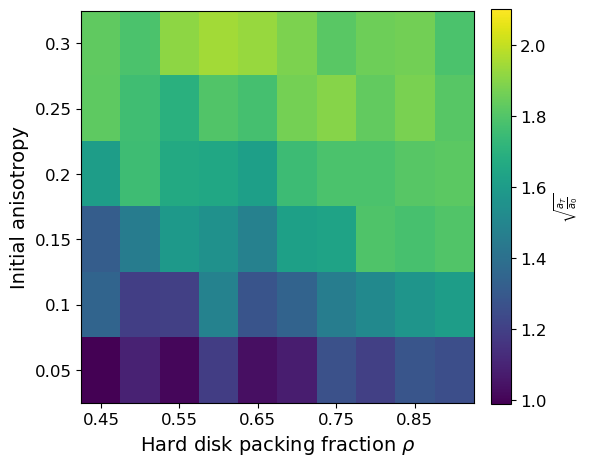

In [ ]:
fig = plt.figure(figsize=(6, 6))

plt.imshow(heatmap.T[::-1,:], aspect=heatmap.shape[0]/heatmap.shape[1], vmin=0.99, vmax=2.1)

plt.xticks(np.arange(len(etas))[::2], etas[::2], fontsize=12)
plt.xlabel(r"Hard disk packing fraction $\rho$", fontsize=14)

plt.yticks(np.arange(len(initial_strains)), initial_strains[::-1], fontsize=12)
plt.ylabel("Initial anisotropy", fontsize=14)

cbar = plt.colorbar(label=r"$\sqrt{\frac{a_T}{a_0}}$", fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
#plt.savefig(f"{plot_dir}/fig_3_phase_diagram/extension_heatmap.pdf")


# maybe I need more realizatons to make the curve smoother ....

plt.savefig(f"{plot_dir}/for_revision/phase_diagram_heatmap_shear_mod_0.0.pdf")
